## Setup

In [1]:
# Adapted from: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

In [2]:
if IS_COLAB:
    %pip install lifelines==0.27.0

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils.sklearn_adapter import sklearn_adapter

## 11.3 The Kaplan-Meier Survival Curve


In [4]:
df_cancer = pd.read_csv(
    'https://raw.githubusercontent.com/wpan03/ISLRv2_Python/main/data/brain_cancer.csv'
)


In [5]:
df_cancer.head()


,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


Most software, including R, uses the convention that status = 1 indicates an uncensored observation, and status = 0 indicates a censored observation. 

In [6]:
df_cancer.status.value_counts()

0    53
1    35
Name: status, dtype: int64

In [7]:
num_survive_20 = df_cancer.query("time >= 20").shape[0]
num_survive_20

48

In [8]:
censor_before_20 = df_cancer.query("time < 20 & status == 0").shape[0]
censor_before_20

17

In [9]:
num_not_censor = df_cancer.query("status == 1").shape[0]
num_survive_20 + num_not_censor - df_cancer.query(
    "time >= 20 & status == 1").shape[0]


71

In [10]:
kmf = KaplanMeierFitter()

In [11]:
kmf.fit(df_cancer['time'], event_observed=df_cancer['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 88 total observations, 53 right-censored observations>

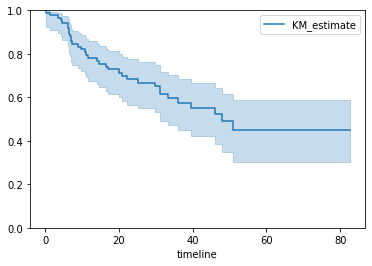

In [12]:
kmf.plot_survival_function()
plt.ylim([0, 1])
plt.show()

## 11.4 Log-Rank Test

In [13]:
df_cancer.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


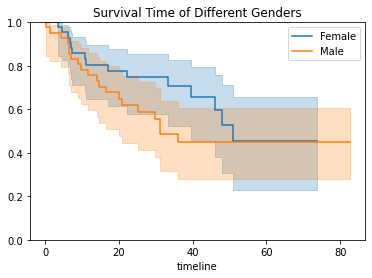

In [14]:
ax = plt.subplot(111)

is_female = (df_cancer["sex"] == "Female")

kmf.fit(df_cancer[is_female]['time'],
        event_observed=df_cancer[is_female]['status'],
        label="Female")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_cancer[~is_female]['time'],
        event_observed=df_cancer[~is_female]['status'],
        label="Male")
kmf.plot_survival_function(ax=ax)

plt.ylim([0, 1])
plt.title("Survival Time of Different Genders")
plt.show()

In [15]:
results = logrank_test(df_cancer[is_female]['time'],
                       df_cancer[~is_female]['time'],
                       df_cancer[is_female]['status'],
                       df_cancer[~is_female]['status'],
                       alpha=.95)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

## 11.5 Regression Models With a Survival Response

### 11.5.3 Brain Cancer Data

In [16]:
df_cancer_with_dummy = pd.get_dummies(df_cancer.dropna())

In [17]:
df_cancer_with_dummy.head(3)

,ki,gtv,status,time,sex_Female,sex_Male,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Infratentorial,loc_Supratentorial,stereo_SRS,stereo_SRT
0,90,6.11,0,57.64,1,0,0,0,1,0,1,0,1,0
1,90,19.35,1,8.98,0,1,1,0,0,0,0,1,0,1
2,70,7.95,0,26.46,1,0,0,0,1,0,1,0,1,0


In [18]:
df_cancer_with_dummy.columns

Index(['ki', 'gtv', 'status', 'time', 'sex_Female', 'sex_Male',
       'diagnosis_HG glioma', 'diagnosis_LG glioma', 'diagnosis_Meningioma',
       'diagnosis_Other', 'loc_Infratentorial', 'loc_Supratentorial',
       'stereo_SRS', 'stereo_SRT'],
      dtype='object')

In [19]:
cph = CoxPHFitter()
cph.fit(
    df_cancer_with_dummy,
    duration_col='time',
    event_col='status',
    formula=
    'ki + gtv + sex_Male + `diagnosis_HG glioma` + `diagnosis_LG glioma` + diagnosis_Other + loc_Supratentorial + stereo_SRT'
)


<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>

In [20]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
diagnosis_HG glioma,2.154566,8.624142,0.450524,1.271555,3.037576,3.566393,20.854639,0.0,4.782354,0.000002,19.138680
diagnosis_LG glioma,0.915024,2.496836,0.638157,-0.335740,2.165788,0.714809,8.721475,0.0,1.433855,0.151614,2.721528
diagnosis_Other,0.885695,2.424669,0.657873,-0.403713,2.175103,0.667836,8.803089,0.0,1.346301,0.178206,2.488386
gtv,0.034293,1.034887,0.022333,-0.009480,0.078065,0.990565,1.081192,0.0,1.535503,0.124660,3.003925
ki,-0.054955,0.946527,0.018314,-0.090849,-0.019061,0.913155,0.981119,0.0,-3.000770,0.002693,8.536580
loc_Supratentorial,0.441195,1.554563,0.703669,-0.937971,1.820360,0.391421,6.174080,0.0,0.626992,0.530664,0.914128
sex_Male,0.183748,1.201712,0.360358,-0.522541,0.890036,0.593012,2.435217,0.0,0.509903,0.610119,0.712837
stereo_SRT,0.177778,1.194560,0.601578,-1.001293,1.356848,0.367404,3.883932,0.0,0.295519,0.767597,0.381579


### 11.5.4 Publication Data

In [21]:
publication_path = 'https://raw.githubusercontent.com/wpan03/ISLRv2_Python/main/data/publication.csv'
df_publication = pd.read_csv(publication_path)

In [22]:
df_publication.head(3)

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
0,0,0,1,R01,39876,8.016941,44.016,11.203285,1
1,0,0,1,R01,39876,8.016941,23.494,15.178645,1
2,0,0,1,R01,8171,7.612606,8.391,24.410678,1


In [23]:
df_publication.status.value_counts()

1    156
0     88
Name: status, dtype: int64

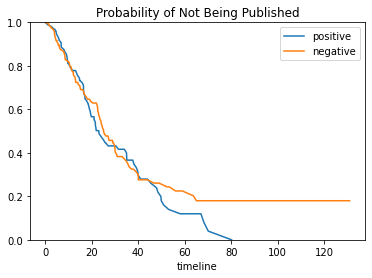

In [24]:
ax = plt.subplot(111)

positive_result = (df_publication["posres"] == 1)

kmf.fit(df_publication[positive_result]['time'],
        event_observed=df_publication[positive_result]['status'],
        label="positive")
kmf.survival_function_.plot(ax=ax)

kmf.fit(df_publication[~positive_result]['time'],
        event_observed=df_publication[~positive_result]['status'],
        label="negative")
kmf.survival_function_.plot(ax=ax)

plt.ylim([0, 1])
plt.title("Probability of Not Being Published")
plt.show()

In [25]:
df_publication_dummy = pd.get_dummies(df_publication, drop_first=True)

In [26]:
df_publication_dummy.head(2)

,posres,multi,clinend,sampsize,budget,impact,time,status,mech_K01,mech_K23,...,mech_P50,mech_R01,mech_R18,mech_R21,"mech_R24, K24",mech_R42,mech_R44,mech_RC2,mech_U01,mech_U54
0,0,0,1,39876,8.016941,44.016,11.203285,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,39876,8.016941,23.494,15.178645,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [27]:
cph = CoxPHFitter()
cph.fit(
    df_publication_dummy,
    duration_col='time',
    event_col='status'
)
cph.summary.round(2)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
posres,0.55,1.74,0.18,0.19,0.91,1.21,2.48,0.0,3.02,0.00,8.62
multi,0.15,1.16,0.31,-0.46,0.75,0.63,2.12,0.0,0.47,0.64,0.65
clinend,0.51,1.67,0.27,-0.02,1.04,0.98,2.83,0.0,1.89,0.06,4.09
sampsize,0.00,1.00,0.00,-0.00,0.00,1.00,1.00,0.0,0.19,0.85,0.24
budget,0.00,1.00,0.00,-0.00,0.01,1.00,1.01,0.0,1.67,0.09,3.41
impact,0.06,1.06,0.01,0.05,0.07,1.05,1.08,0.0,8.23,0.00,52.27
mech_K01,1.05,2.86,1.06,-1.02,3.12,0.36,22.69,0.0,1.00,0.32,1.65
mech_K23,-0.48,0.62,1.05,-2.54,1.59,0.08,4.89,0.0,-0.45,0.65,0.62
mech_P01,-0.31,0.73,0.78,-1.83,1.22,0.16,3.37,0.0,-0.40,0.69,0.53


## 11.6 Shrinkage for the Cox Modle

In [28]:
x = df_publication_dummy.drop('time', axis=1) # keep as a dataframe
y = df_publication_dummy['time']

In [29]:
cox_regression = sklearn_adapter(CoxPHFitter, event_col='status')

In [30]:
sk_cph = cox_regression(penalizer=1e-3, l1_ratio=1)
sk_cph.fit(x, y)

SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=1, n_baseline_knots=None,
                   penalizer=0.001, strata=None)

In [31]:
sk_cph.lifelines_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
posres,0.546840,1.727785,0.182699,0.188756,0.904925,1.207746e+00,2.471745,0.0,2.993115,2.761455e-03,8.500356
multi,0.137383,1.147267,0.307903,-0.466097,0.740862,6.274466e-01,2.097744,0.0,0.446188,6.554614e-01,0.609417
clinend,0.509435,1.664351,0.270510,-0.020754,1.039624,9.794597e-01,2.828154,0.0,1.883242,5.966763e-02,4.066908
sampsize,0.000003,1.000003,0.000015,-0.000026,0.000032,9.999737e-01,1.000032,0.0,0.187897,8.509575e-01,0.232841
budget,0.004189,1.004197,0.002515,-0.000740,0.009117,9.992601e-01,1.009159,0.0,1.665617,9.578966e-02,3.383986
impact,0.059975,1.061810,0.007296,0.045674,0.074275,1.046733e+00,1.077103,0.0,8.219993,2.035152e-16,52.125713
mech_K01,1.033297,2.810316,1.063268,-1.050669,3.117263,3.497036e-01,22.584476,0.0,0.971813,3.311438e-01,1.594470
mech_K23,-0.445724,0.640361,1.035300,-2.474874,1.583427,8.417356e-02,4.871622,0.0,-0.430526,6.668129e-01,0.584646
mech_P01,-0.294899,0.744607,0.771254,-1.806529,1.216731,1.642232e-01,3.376132,0.0,-0.382363,7.021919e-01,0.510063
